## Radiator Folie

Er wordt gebruik gemaakt van het eerder geschreven programma Heat_Convection.py, dat in staat is warmte-stromen als gevolg van convectie in zowel vrije lucht als geforceerde stroming exact te berekenen.
De benaderings formules zijn gemaakt door Robbert Mientki.


## Imports

In [1]:
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))
#body { font-size: 20px; }
from IPython.core.display import display, HTML

import numpy as np
import traceback
from scipy.constants import Stefan_Boltzmann
from scipy.optimize import toms748

# Constanten
Ketel_Rendement = 0.6   # hoge temperaturen, leidingverlies en geen verkooppraatjes
kWh_per_m3gas   = 9.8

## Model

Voor het bekijken van het effect van het toepassen van Radiator Folie zijn we alleen geïnteresseerd in de warmte die door de muur achter de radiator verdwijnt. Bij het model hebben we in eerste instantie voornamelijk te maken met drie warmtestromen, die met elkaar in evenwicht moeten zijn, dit zijn :
- het stralingstransport tussen radiator en muur
- de geleiding door de muur als gevolg van het temperatuurverschil tussen binnen en buiten
- de convectie van de muur als gevolg van de verhoogde temperatuur van de muur
De component geleiding van lucht naar muur (dus het omgekeerde van de laatste convectie) wordt klein verondersteld en is daarom verwaarloosd. Eventueel kunnen we het effect hiervan bekijken na het aanbrengen van de radiator folie.

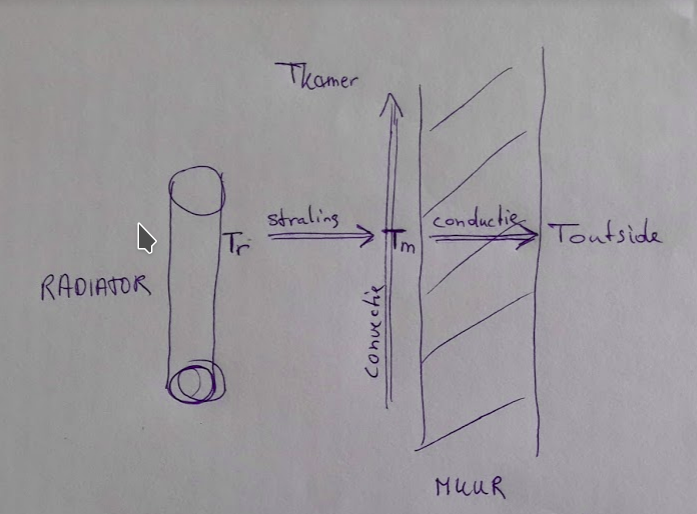

In dit geval krijgen we de volgende vergelijking (de drie hoofdelementen zijn hier in Watt/m2:

$$ \large{\epsilon * Bolzmann * ( T_r ^4 - T_m ^4 ) = \frac { T_m - T_{buiten}}{R_m} - 4.5 * ( T_m - T_{kamer} )}$$

Deze vergelijking is niet analytisch op te lossen dus zullen we een benadering moeten vinden (VBA in Excel heeft voor zover bekend geen solvers aan boord).
<br>De argumenten in de vergelijking zijn:
<br>$\large \epsilon = Emissiviteit \, van \, de \, Radiator$
<br>$\large B = Bolzmann \, Constante \, (k_b)$
<br>$\large R_m = R_{muur} \, = \, Warmteweerstand \, van \, de \, Muur \, [W/m2.K]$
<br>$\large T_b = T_{buiten} = Gemiddelde \, BuitenTemperatuur \,[K]$
<br>$\large T_k = T_{kamer} = Gemiddelde \, Temperatuur \, in \, de \, Kamer \, [K]$
<br>$\large T_m = T_{muur} = Gemiddelde \, Temperatuur \, van \, de \, Muur \, [K]$
<br>$\large T_r = T_{radiator} = Gemiddelde \, Radiator \, Temperatuur \, [K]$
<br><br>


## Benadering

(Door Robbert Mientki)
<br>Stel de oplossing $\large T_m$ ligt rond een goed gekozen (of eventueel) later gevonden) werkpunt $\large T_w$ :
<br><br>$$\large T_{m}=T_{w}+T_{x}$$
<br>Met als randvoorwaarde dat de oplossing in de buurt van het werkpunt ligt, dus $\large T_x$ klein
<br><br>$$\large T_{x}<<T_{w}$$
<br>In dat geval kunnen we $\large T_m^4$ als volgt opschrijven
<br><br>$$\large T_{m}^{4}=\left(T_w+T_{x}\right)^{4}=T_{w}^{4}+4 T_{w}^{3} T_{x}+6 T_{n}^{2} T_{x}^{2}+4 T_{w} T_{x}^{3}+T_{x}^{4}$$
<br>Als $\large T_x$ klein is, kunnen we de hogere machten van $\large T_x$ verwaarlozen en zijn alleen de eerste 2 termen van belang
<br><br>$$\large T_{m}^{4} \approx T_{w}^{4}+4 T_{w}^{3} T_{x}$$
<br>En nu hebben we een lineaire uitdrukking voor $\large T_m^4$, immers $\large T_w$ is een constante en dus kunnen we analytisch de oplossing berekenen.
<br>Als we nu $\large T_m$ substitueren, krijgen we een lineaire vergelijking in $\large T_x$
<br><br>$$\large \varepsilon+B *\left(T_{r}^{4}-T_{w}^{4}-4 T_{w}^{3} T_{x}\right)=
 \frac{T_{w}+T_{x}-T_{b}}{R_{m}}+4.5\left(T_{w}+T_{x}-T_ k\right)$$
<br>halen we nu $\large T_x$ naar 1 kant, dan krijgen we de volgende notatie
<br><br>$$\large  T_{x}\left(4.5+\frac{1}{R_{m}}+4 T_{w}^{3} * \varepsilon * B\right)=
 \epsilon * B * ( T_r^4 - T_w^4 ) - \frac{ ( T_w-T_b ) }{R_m}-4.5 (T_w-T_k )$$
 
en ten slotte kunnen we dus de analytische oplossing beschrijven als
<br><br>$$\large T_{x}=\frac{\varepsilon * B * ( T_r^4-T_w^4 ) - \frac{ ( T_w-T_b )}{R_m}-4.5 (T_w-T_k )}{4 * \epsilon * B * T_w^3 + \frac{1}{R_m } + 4.5 }$$

<br><br>laten we maar eens kijken wat deze formule oplevert.
<br> Als eerste werkpunt nemen we het gemiddelde van Radiator Temperatuur en Kamer Temperatuur

In [2]:
Rm = Rmuur = 2
Emissivity = 0.95
EB = Emissivity * Stefan_Boltzmann 

Tb = Tbuiten   =  0 + 273
Tk = Tkamer    = 20 + 273
Tr = Tradiator = 70 + 273

Tw = ( Tr + Tk ) / 2
Tm = EB * ( Tr**4 - Tw**4 ) - ( Tw - Tb ) / Rm - 4.5 * ( Tw - Tk )
Tm = Tw + Tm / ( EB * 4 * Tw**3 + 1/Rm + 4.5 )
print ( "Benadering:", Tm - 273 )

Benadering: 50.00848279211766


## Vergelijk met solver
De uitkomst ziet er niet heel vreemd uit.
<br>Laten we hem eens vergelijken met de echte waarde, we kunnen namelijk de echte vergelijking in een solver stoppen, die op iteratieve wijze het echte antwoord gaat geven. We gebruiken hiervor Toms748 https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.toms748.html

In [3]:
def Vergelijking ( Tm, EB, Rm, Tr, Tk, Tb ) :
  return EB * ( Tr**4 - Tm**4 ) - ( Tm - Tb ) / Rm - 4.5 * ( Tm - Tk )
Tm = toms748 ( Vergelijking, Tk , Tr, ( EB, Rm, Tr, Tk, Tb ) )
print ( 'Echte Oplossing:', Tm - 273 )

Echte Oplossing: 49.94089974379358


De eerste vergelijking ziet er heel goed uit (minder dan 0.1 Celsius verschil). Maar we moeten natuurlijk het hele werkgebied waarin we geïnteresseerd zijn verkennen. Dit werkgebied omvat:
- R = 1 .. 5  [W/m2.K]
- Tr = 30 .. 70 [Celsius]
- Emissiviteit = 0.05 .. 0.95

Dus we stoppen onze benadering in een functie

In [4]:
# ***************************************************************************
def T_Muur_Approx ( EB, Rm, Tr, Tk, Tb ) :
  Tw = ( Tr + Tk ) / 2
  Tm = EB * ( Tr**4 - Tw**4 ) - ( Tw - Tb ) / Rm - 4.5 * ( Tw - Tk )
  Tm = Tw + Tm / ( EB * 4 * Tw**3 + 1/Rm + 4.5 )
  return Tm - 273

En tasten het hele werkgebied af .... in 1 woord perfect !!

In [5]:
# ***************************************************************************
print ( "Temp\tRm\te\tToms\tBenadering" )
for Rm in ( 1, 2, 3, 5 ) :
  for Emissivity in ( 0.95, 0.05 ) :
    EB = Emissivity * Stefan_Boltzmann 
    for T in ( 70, 60, 50, 40, 30 ) :
      Tr = T + 273
      try :
        Toms = toms748 ( Vergelijking, Tb , Tr, ( EB, Rm, Tr, Tk, Tb ) ) - 273 
      except:
        #traceback.print_exc ()
        Toms = -1
        pass
      print ( '%i\t%.1f\t%.2f\t%.2f\t %.2f' % ( T, Rm, Emissivity,
        Toms,
        T_Muur_Approx ( EB, Rm, Tr, Tk, Tb )) )
    print ()

Temp	Rm	e	Toms	Benadering
70	1.0	0.95	47.97	 48.00
60	1.0	0.95	41.26	 41.27
50	1.0	0.95	34.92	 34.92
40	1.0	0.95	28.95	 28.95
30	1.0	0.95	23.36	 23.37

70	1.0	0.05	19.71	 19.89
60	1.0	0.05	18.96	 19.08
50	1.0	0.05	18.26	 18.34
40	1.0	0.05	17.63	 17.67
30	1.0	0.05	17.06	 17.08

70	2.0	0.95	49.94	 50.01
60	2.0	0.95	43.02	 43.05
50	2.0	0.95	36.46	 36.47
40	2.0	0.95	30.27	 30.27
30	2.0	0.95	24.46	 24.46

70	2.0	0.05	21.58	 21.75
60	2.0	0.05	20.75	 20.86
50	2.0	0.05	19.99	 20.06
40	2.0	0.05	19.30	 19.34
30	2.0	0.05	18.68	 18.69

70	3.0	0.95	50.63	 50.72
60	3.0	0.95	43.64	 43.67
50	3.0	0.95	37.00	 37.01
40	3.0	0.95	30.73	 30.74
30	3.0	0.95	24.85	 24.85

70	3.0	0.05	22.28	 22.44
60	3.0	0.05	21.43	 21.53
50	3.0	0.05	20.64	 20.71
40	3.0	0.05	19.93	 19.96
30	3.0	0.05	19.28	 19.29

70	5.0	0.95	51.19	 51.30
60	5.0	0.95	44.14	 44.19
50	5.0	0.95	37.44	 37.46
40	5.0	0.95	31.12	 31.12
30	5.0	0.95	25.17	 25.17

70	5.0	0.05	22.88	 23.03
60	5.0	0.05	22.00	 22.10
50	5.0	0.05	21.20	 21.26
40	5.0	0.05	20.46

## Besparing per m2
Nu we weten dat de benadering correct werkt, kunnen we een inschatting van de energiebesparing gaan maken. In eerste instantie bepalen we de besparing per m2 bij een bepaalde radiator temperatuur. In een volgende stap zullen we de resultaten proberen te vertalen naar jaargemiddelden.

In [6]:

# ***************************************************************************
EB1 = 0.95 * Stefan_Boltzmann 
EB2 = 0.05 * Stefan_Boltzmann 
print ( "Temp\tRm\tTzonder\tTmet\tEzonder\tEmet\tEdelta" )
for Rm in ( 1, 2, 3, 5 ) :
  for T in ( 70, 60, 50, 40, 30, 20 ) :
    Tr = T + 273
    T_zonder = T_Muur_Approx ( EB1, Rm, Tr, Tk, Tb )
    T_met    = T_Muur_Approx ( EB2, Rm, Tr, Tk, Tb )
    E_zonder = ( T_zonder + 273 - Tb ) / Rm
    E_met    = ( T_met + 273 - Tb ) / Rm
    print ( '%i\t%.1f\t%i\t%i\t%.1f\t%.1f\t%.1f' % ( T, Rm, T_zonder, T_met, E_zonder, E_met, E_zonder-E_met ))
  print ()

Temp	Rm	Tzonder	Tmet	Ezonder	Emet	Edelta
70	1.0	47	19	48.0	19.9	28.1
60	1.0	41	19	41.3	19.1	22.2
50	1.0	34	18	34.9	18.3	16.6
40	1.0	28	17	29.0	17.7	11.3
30	1.0	23	17	23.4	17.1	6.3
20	1.0	18	16	18.2	16.5	1.6

70	2.0	50	21	25.0	10.9	14.1
60	2.0	43	20	21.5	10.4	11.1
50	2.0	36	20	18.2	10.0	8.2
40	2.0	30	19	15.1	9.7	5.5
30	2.0	24	18	12.2	9.3	2.9
20	2.0	19	18	9.5	9.1	0.5

70	3.0	50	22	16.9	7.5	9.4
60	3.0	43	21	14.6	7.2	7.4
50	3.0	37	20	12.3	6.9	5.4
40	3.0	30	19	10.2	6.7	3.6
30	3.0	24	19	8.3	6.4	1.9
20	3.0	19	18	6.4	6.2	0.2

70	5.0	51	23	10.3	4.6	5.7
60	5.0	44	22	8.8	4.4	4.4
50	5.0	37	21	7.5	4.3	3.2
40	5.0	31	20	6.2	4.1	2.1
30	5.0	25	19	5.0	4.0	1.1
20	5.0	19	19	3.9	3.8	0.1



## Benadering 1: graaddagen
Bij alle benaderingen gaan we uit van onze eigen situatie. Deze wordt gekenmerkt door
- zeer zuinig stookgedrag
- 2.5 m2 radiator oppervlakte dat regelmatig gebruikt wordt
- hoge keteltemperatuur: 75/65 Celsius
- spouwmuur met 5 cm isover en 5 cm matig geventileerde spouw
- s'nachts gaat de verwarming helemaal uit



Bij deze benadering maken we een schatting van hoeveel tijd dat de radiatoren op gemiddeld
We hebben ongeveer 2800 graaddagen per jaar.
<br>Als we willen weten hoeveel dagen van gemiddeld 20 Celsius verschil we hebben, krijgen we 2800 / 20 = 140 dagen.
Per dag verwarmen we ongeveer 16 uur. Bij 20 Celsius verschiltussen binnen en buiten temperatuur draait de verwarmingsketel ongeveer de helft van de tijd, dus 8 uur.

In [7]:
Oppervlak         = 2.5
GraadDagen        = 2800
GraadDagen_20     = GraadDagen / 20
Stooktijd_per_Dag = 8
Rmuur             = 2
Tradiator         = 70
Ezonder           = 25
Emet              = 10.9

Verlies_Zonder_Folie = ( Oppervlak * GraadDagen_20 * Stooktijd_per_Dag * Ezonder ) / 1000
Verlies_Met_Folie    = ( Oppervlak * GraadDagen_20 * Stooktijd_per_Dag * Emet    ) / 1000
Winst_kWh            = Verlies_Zonder_Folie - Verlies_Met_Folie
print ( "Winst        per jaar = %3i kWh,    Zonder-Folie = %i kWh,     Met-Folie = %i kWh" % (Winst_kWh, Verlies_Zonder_Folie, Verlies_Met_Folie))
print ( "Winst per m2 per jaar = %3.1f kWh" % ( Winst_kWh / Oppervlak ))

Winst        per jaar =  39 kWh,    Zonder-Folie = 70 kWh,     Met-Folie = 30 kWh
Winst per m2 per jaar = 15.8 kWh


## Benadering 2: Web
Op vele plaatsen vind je dezelfde tabel, zonder dat ik hiervan ergens de bron of berekeningen heb kunnen vinden. Het vermoeden is dat iedereen deze tabel zonder kritische blik overneemt. 
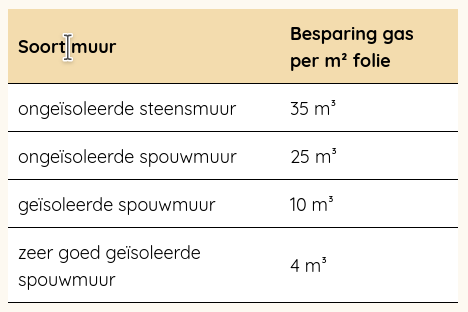
In ons voorbeeld hebben we een "geisoleerde wand" en dus zouden we een besparing van 10 m3 gas / jaar moeten kunnen behalen. https://www.zelfenergiebesparen.nl/gas-besparen/radiatorfolie/

Milieucentraal geeft slechts 1 getal: 10 m3 gas / jaar
https://www.milieucentraal.nl/energie-besparen/snel-besparen/bespaartips-verwarming/
Tozon, neemt vervolgens, met verwijzing naar MileuCentraal deze waarde op in hun brochures. Dit leidt bij mij tot het gevoeld dat de besparing hier optimistisch wordt voorgesteld, anders zou een fabrikant toch wel hun eigen betere waarden hanteren.

De Homerus menukaart (gegevens over een uitgebreide set besparings mogelijkheden) https://www.de-a.nl/wp-content/uploads/2019/07/190514-Menukaart-Homerus-Energiek-V2.pdf?utm_source=mailpoet&utm_medium=email&utm_campaign=Homerus+Energiek+5  komt na omrekening op 7.5 m3 gas / jaar

In [8]:
# 10 m3 per m2 per jaar
Besparing_1 = 10 * Ketel_Rendement * kWh_per_m3gas
print ( "Artikel 1, Besparing per m2 per jaar = %i kWh" % ( Besparing_1 ))

# 7.5 m3 per m2 per jaar
Besparing_3 = 7.5 * Ketel_Rendement * kWh_per_m3gas
print ( "Artikel 3, Besparing per m2 per jaar = %i kWh" % ( Besparing_3 ))


Artikel 1, Besparing per m2 per jaar = 58 kWh
Artikel 3, Besparing per m2 per jaar = 44 kWh


## Benadering 3: gasverbruik

In een normaal huis, met een "beetje" spouwmuur-isolatie (ruime periode rondom 1985) geldt een Rmuur van ongeveer 2. Van het gasverbruk wordt dan gemiddeld zo'n 80% verbuikt voor het verwarmen van de woning. Dus als we het gasvebruik weten, kunnen we de thermische energie die hiermee gemaakt wordt berekenen en vervolgens stellen we dat de helft van de stralingswarmte (immers de ander helft straalt de kamer(s) in) verdwijnt in de muur en vervolgens naar buiten. Een goede radiator folie houdt meer dan 95% van die stralingsenergie tegen.
<br> De meest voorkomende radiatortypen zijn 21 en 22, met respectievelijk 30% en 27% straling (bij 76/65), dan is 28.5% straling een goede keuze (maximaal de helft hiervan gaat de muur in).

In [9]:
GasVerbruik        =  1500  # [m3/jaar]
Verwarming_m3_gas  = 0.8 * 1500
Radiation          = 0.1425 * Verwarming_m3_gas
print ( "Besparing m3 gas        per jaar = %4i m3" % Radiation )
print ( "Besparing m3 gas per m2 per jaar = %4i m3" % ( Radiation / Oppervlak ))

Besparing m3 gas        per jaar =  170 m3
Besparing m3 gas per m2 per jaar =   68 m3


Dit is belachelijk hoog. Ik heb nog geen flauw idee waar dit model de fout in gaat.
Als we ketelrendement (let op voor hoge temperaturen en geen verkooppraatjes) op 60% stellen, komt dat elektrisch overeen met :

In [10]:
print ( "Besparing Elektra per m2 per jaar = %i kWh" % ( Ketel_Rendement * kWh_per_m3gas * Radiation / Oppervlak ))

Besparing Elektra per m2 per jaar = 402 kWh


In [11]:
Th = 70 + 273
T1 = 20 + 273
T2 = 50 + 273
A = int ( Stefan_Boltzmann * ( Th**4-T1**4 ) )
B = int ( Stefan_Boltzmann * ( Th**4-T2**4 ) )
print ( A, B, A - B )

366 167 199


Zoals hierboven berekend, als we de verkeerde muur temperatuur nemen scheelt dat ongeveer een factor 2, dus dat verklaart nog lang niet genoeg.

## Benadering 4: meer literatuur

https://www.researchgate.net/publication/224564071_Reflecting_panels_for_radiators_in_residential_buildings_Theoretical_analysis_of_energy_erformance
R = 0.3  ==>  besparing 8%
R = 0.9  ==>  besparing 3%
R = 3    ==>  besparing 0.7 %


The Effect of Wall Emissivity on Radiator Heat Output
http://eprints.whiterose.ac.uk/121224/7/paper%2024.pdf
experimenten, maar niet direct duidelijk. Neemt wel de convectie van de muur mee
Tradiator 80 Celsius ?
Qrad daalt van 60 naar 5..10 W

http://www.vesma.com/downloads/radiator_foil.pdf
TRadiator = 80 Celcius, 
R = 0.67  ==>  besparing 67 kWh
R = 1.67  ==>  besparing 12 kWh
dus ruwe schatting hieruit
R = 1   ==> Besparing 50 kWh
R = 3  ==>  Besparing  8 kWh



In [12]:
# voor het eerste artikel, R=2 : besparing 1%
Besparing_1 = 6 * 0.01 * Verwarming_m3_gas
print ( "Artikel 1, Besparing per m2 per jaar = %i kWh" % ( Besparing_1 ))


# voor het tweede artikel
Besparing_2 = ( GraadDagen_20 * Stooktijd_per_Dag * 55 ) / 1000
print ( "Artikel 2, Besparing per m2 per jaar = %i kWh" % ( Besparing_2 ))

Besparing_3 = 35
print ( "Artikel 3, Besparing per m2 per jaar = %i kWh" % ( Besparing_3 ))

Artikel 1, Besparing per m2 per jaar = 72 kWh
Artikel 2, Besparing per m2 per jaar = 61 kWh
Artikel 3, Besparing per m2 per jaar = 35 kWh


## Conclusie
Als we bovenstaande verschilende methoden in een tabel zetten, dan gelden voor een Rmuur = 2 en een gemiddelde radiator temperatuur van 70 Celcius volgens de verschillende rekenmethoden de volgende waarden:

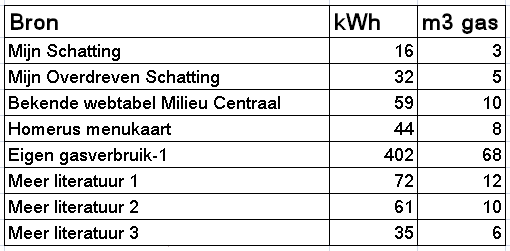

De meeste "beweringen" komen uit op een besparing van 8 .. 10 m3 gas per m2.
Mijn berekening komt slechts uit op 3 m3 gas / m2.
Als we ook nog eens in ogenschouw nemen dat de gemiddelde radiator temperatuur eiegenlijk niet hoger dan 50 Celsius zou moeten zijn, dan moeten we concluderen dat radiator folie nauwelijks zin heeft.